## Weight Initialization

In machine learning, weight initialization is the process of setting the initial values of the weights in a neural network. Proper weight initialization is crucial because it can significantly impact the training process and the overall performance of the model.

There are several techniques for weight initialization, and the choice of method depends on the specific architecture of the neural network and the activation functions used. Here we will describe some of them.

### Initialization with Same Weights

In [105]:
# import the libraries 
import torch
import torch.nn as nn
from torch import sigmoid
import matplotlib.pylab as plt
import numpy as np
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.functional as F

torch.manual_seed(0)

In [65]:
# The function for plotting the model

def PlotStuff(X, Y, model, epoch, leg=True):
    
    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))
    plt.plot(X.numpy(), Y.numpy(), 'r')
    plt.xlabel('x')
    if leg == True:
        plt.legend()
    else:
        pass

In [66]:
# define the class Net
class Net(nn.Module):
    #Constructor
    def __init__(self,D_in,H,D_out):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(D_in,H)
        self.linear2 = nn.Linear(H,D_out)
    #Prediction
    def forward(self,x):
        self.l1 = self.linear1(x)
        self.a1 = sigmoid(self.l1)
        self.l2 = self.linear2(self.a1)
        yhat = sigmoid(self.linear2(self.a1))
        return yhat 
        

In [67]:
# Define the training function

def train(Y, X, model, optimizer, criterion, epochs=1000):
    cost = []
    total=0
    for epoch in range(epochs):
        total=0
        for y, x in zip(Y, X):
            yhat = model(x)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            #cumulative loss 
            total+=loss.item() 
        cost.append(total)
        if epoch % 300 == 0:    
            PlotStuff(X, Y, model, epoch, leg=True)
            plt.show()
            model(X)
            plt.scatter(model.a1.detach().numpy()[:, 0], model.a1.detach().numpy()[:, 1], c=Y.numpy().reshape(-1))
            plt.title('activations')
            plt.show()
    return cost

In [68]:
# make dataset

X = torch.arange(-20,20,1).view(-1,1).type(torch.FloatTensor)
Y = torch.zeros(X.shape[0])
Y[(X[:,0]>-4) & (X[:,0]<4)] = 1.0

In [69]:
def criterion_cross(outputs, labels):
    out = -1 * torch.mean(labels * torch.log(outputs) + (1 - labels) * torch.log(1 - outputs))
    return out

In [70]:
D_in = 1
H = 2
D_out = 1
learning_rate = 0.1
model = Net(D_in, H, D_out)

In [71]:
# the value of the weight and bias in each layer
model.state_dict()

OrderedDict([('linear1.weight',
              tensor([[-0.0075],
                      [ 0.5364]])),
             ('linear1.bias', tensor([-0.8230, -0.7359])),
             ('linear2.weight', tensor([[-0.2723,  0.1896]])),
             ('linear2.bias', tensor([-0.0140]))])

In [72]:
# we can manipulate the value of weight and bias in each layer
model.state_dict()['linear1.weight'][0]=1.0
model.state_dict()['linear1.weight'][1]=1.0
model.state_dict()['linear1.bias'][0]=0.0
model.state_dict()['linear1.bias'][1]=0.0
model.state_dict()['linear2.weight'][0]=1.0
model.state_dict()['linear2.bias'][0]=0.0
model.state_dict()

OrderedDict([('linear1.weight',
              tensor([[1.],
                      [1.]])),
             ('linear1.bias', tensor([0., 0.])),
             ('linear2.weight', tensor([[1., 1.]])),
             ('linear2.bias', tensor([0.]))])

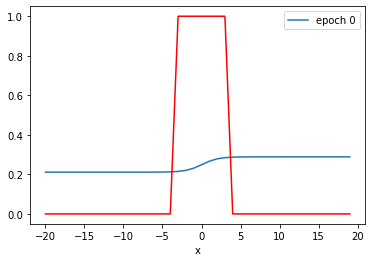

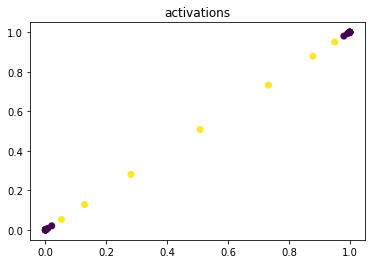

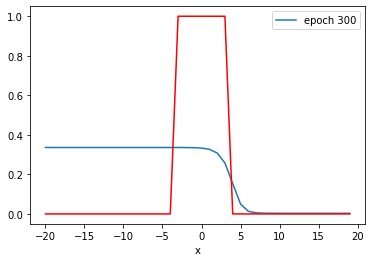

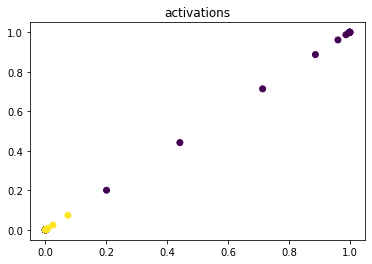

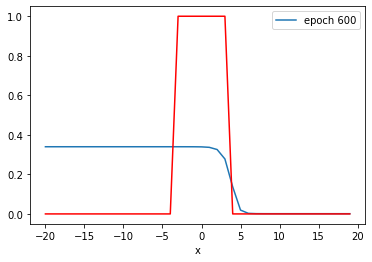

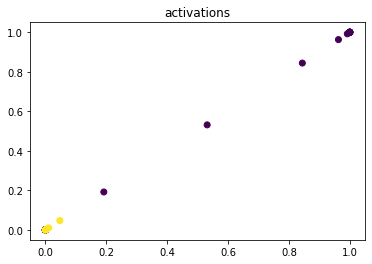

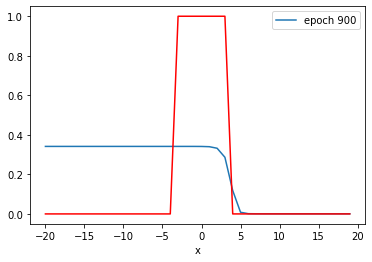

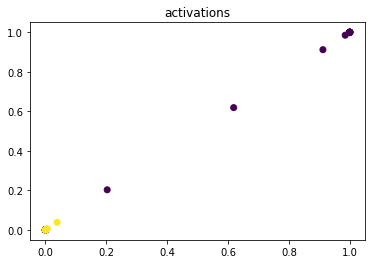

Text(0.5, 1.0, 'cross entropy loss')

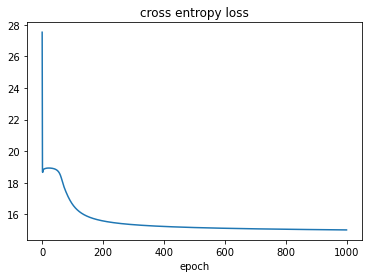

In [73]:
#optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#train the model usein
cost_cross = train(Y, X, model, optimizer, criterion_cross, epochs=1000)
#plot the loss
plt.plot(cost_cross)
plt.xlabel('epoch')
plt.title('cross entropy loss')

In [74]:
model.state_dict() #this code clearly shows that the value of the output is identical even after a lot of change

OrderedDict([('linear1.weight',
              tensor([[1.9340],
                      [1.9340]])),
             ('linear1.bias', tensor([-9.0725, -9.0725])),
             ('linear2.weight', tensor([[-3.3976, -3.3976]])),
             ('linear2.bias', tensor([-0.6546]))])

### Random Initialization

In [75]:
D_in = 1
H = 2
D_out = 1
learning_rate = 0.1
model = Net(D_in, H, D_out)

In [77]:
model.state_dict() # choosing random initialization 

OrderedDict([('linear1.weight',
              tensor([[ 0.7929],
                      [-0.0887]])),
             ('linear1.bias', tensor([ 0.2646, -0.3022])),
             ('linear2.weight', tensor([[-0.1390, -0.6755]])),
             ('linear2.bias', tensor([-0.4683]))])

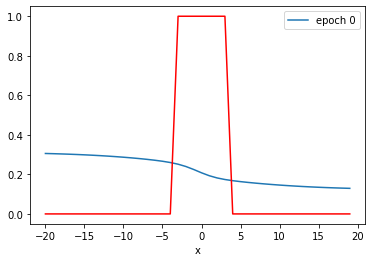

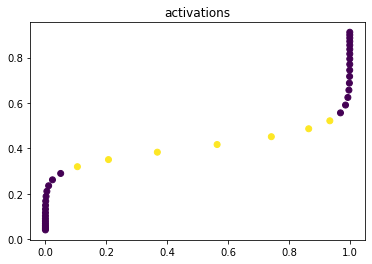

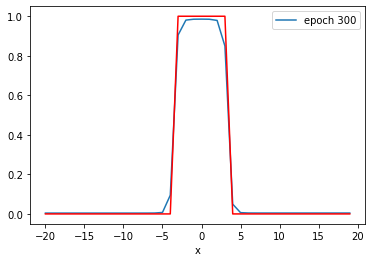

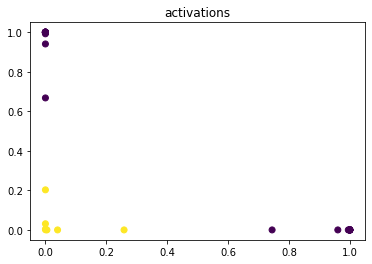

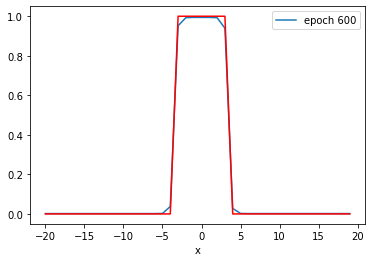

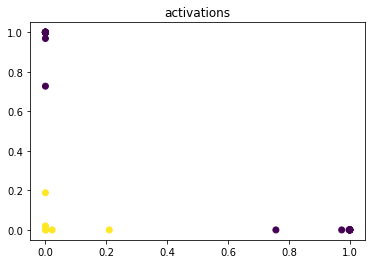

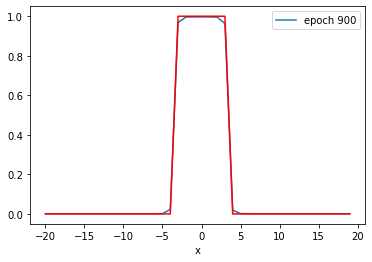

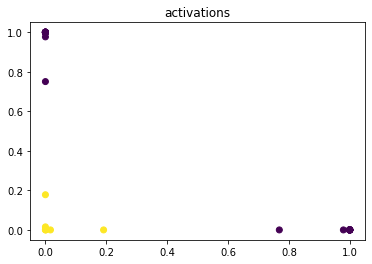

Text(0.5, 1.0, 'cross entropy loss')

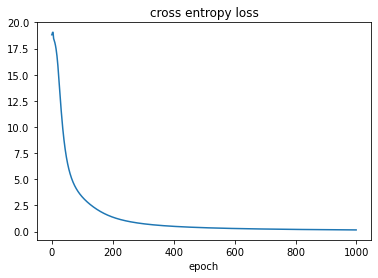

In [78]:
#optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#train the model usein
cost_cross = train(Y, X, model, optimizer, criterion_cross, epochs=1000)
#plot the loss
plt.plot(cost_cross)
plt.xlabel('epoch')
plt.title('cross entropy loss')

### Xavier Initialization

In [86]:
# Define the neural network with Xavier initialization

class Net_Xavier(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        super(Net_Xavier, self).__init__()
        self.hidden = nn.ModuleList()

        for input_size, output_size in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_size, output_size)
            torch.nn.init.xavier_uniform_(linear.weight)
            self.hidden.append(linear)
    
    # Prediction
    def forward(self, x):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = torch.tanh(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

In [87]:
# function to Train the model

def train(model, criterion, train_loader, validation_loader, optimizer, epochs = 100):
    i = 0
    loss_accuracy = {'training_loss':[], 'validation_accuracy':[]}  
    
    for epoch in range(epochs):
        for i,(x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_accuracy['training_loss'].append(loss.data.item())
            
        correct = 0
        for x, y in validation_loader:
            yhat = model(x.view(-1, 28 * 28))
            _, label = torch.max(yhat, 1)
            correct += (label==y).sum().item()
        accuracy = 100 * (correct / len(validation_dataset))
        loss_accuracy['validation_accuracy'].append(accuracy)
        
    return loss_accuracy

In [88]:
# Create the train dataset
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
# Create the validation dataset
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
# Create Dataloader for both train dataset and validation dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)

In [89]:
# Define criterion function
criterion = nn.CrossEntropyLoss()

In [90]:
# Set the parameters
input_dim = 28 * 28
output_dim = 10
layers = [input_dim, 100, 10, 100, 10, 100, output_dim]
epochs = 15

In [91]:
model_Xavier = Net_Xavier(layers)
optimizer = torch.optim.SGD(model_Xavier.parameters(), lr=learning_rate)
training_results_Xavier = train(model_Xavier, criterion, train_loader, validation_loader, optimizer, epochs=epochs)

Text(0.5, 1.0, 'training loss iterations')

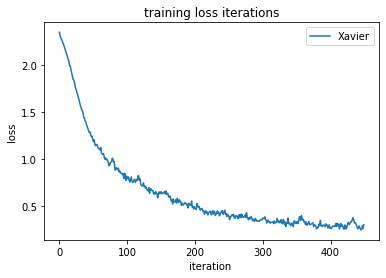

In [95]:
plt.plot(training_results_Xavier['training_loss'], label='Xavier')
plt.legend()
plt.ylabel('loss')
plt.xlabel('iteration ')  
plt.title('training loss iterations')

Text(0, 0.5, 'validation accuracy')

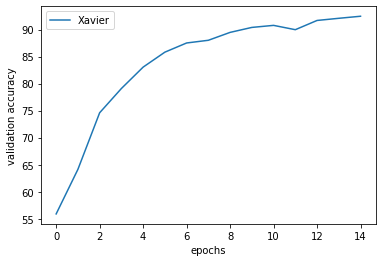

In [98]:
plt.plot(training_results_Xavier['validation_accuracy'], label='Xavier')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('validation accuracy')

### He Initialization

In [99]:
# Define the class for neural network model with He Initialization

class Net_He(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        super(Net_He, self).__init__()
        self.hidden = nn.ModuleList()

        for input_size, output_size in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_size, output_size)
            torch.nn.init.kaiming_uniform_(linear.weight, nonlinearity='relu')
            self.hidden.append(linear)

    # Prediction
    def forward(self, x):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = F.relu(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

In [104]:
# Define criterion function
criterion = nn.CrossEntropyLoss()
# Set the parameters
input_dim = 28 * 28
output_dim = 10
layers = [input_dim, 100, 10, 100, 10, 100, output_dim]
epochs = 15


In [106]:
model_He = Net_He(layers)
optimizer = torch.optim.SGD(model_He.parameters(), lr=learning_rate)
training_results_He = train(model_He, criterion, train_loader, validation_loader, optimizer, epochs=30)

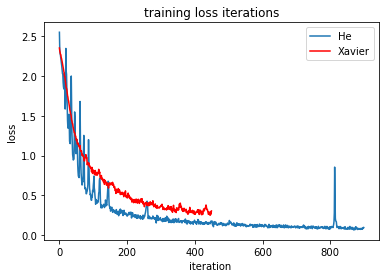

In [108]:
plt.plot(training_results_He['training_loss'], label='He')
plt.plot(training_results_Xavier['training_loss'],c = 'r', label='Xavier')
plt.ylabel('loss')
plt.xlabel('iteration ') 
plt.title('training loss iterations')
plt.legend()

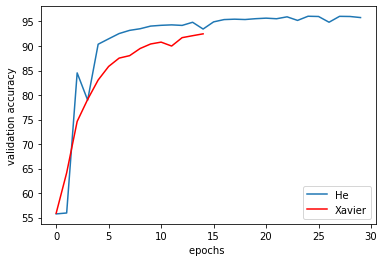

In [109]:
plt.plot(training_results_He['validation_accuracy'], label='He')
plt.plot(training_results_Xavier['validation_accuracy'], c= 'r', label='Xavier')
plt.ylabel('validation accuracy')
plt.xlabel('epochs ')   
plt.legend()
plt.show()